### Explore rio and filtering
1) Read in my 3d array of elevations, which are on a rotated grid in "island" coordinates, x = alongshore and y = cross-shore  
2) Determine the UTM coordinates of the grid  
3) Make a regular grid of UTM coordinates  
4) Interpolate the values from the rotated coords onto the regular grid  
5) Write out a .tiff file...ideally a COG geotiff.  

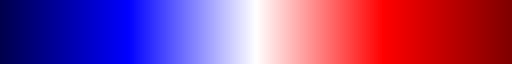

In [1]:
import numpy as np
import rioxarray
import xarray as xr

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from datetime import datetime
import pickle

from scipy import interpolate, signal
from astropy.convolution import Gaussian2DKernel
from astropy.convolution import convolve as astropy_convolve
from scipy.signal import convolve as scipy_convolve
from CoreBx_funcs import *

import warnings
warnings.filterwarnings('ignore')

# These commands choose fonts that are editable in svg format
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

# colors
dblue = '#1f77b4'
red3 = ['#fee0d2','#fc9272','#de2d26']
# oranges from ColorBrewer https://colorbrewer2.org/#type=sequential&scheme=PuBu&n=5
cols=['#feedde','#fdbe85','#fd8d3c','#e6550d','#a63603']
blue5=['#f1eef6','#bdc9e1','#bdc9e1','#2b8cbe','#045a8d']
green5=['#edf8e9','#bae4b3','#74c476','#31a354','#006d2c']
purple5 = ['#f2f0f7','#cbc9e2','#9e9ac8','#756bb1','#54278f']

# This is the colormap made in SurferClr2Cmap.ipynb from NorthCore_ElevationShader_v2.clr
fp = open('cmap_ncb.pkl', 'rb')
cmap_ncb = pickle.load(fp)
fp.close()

# This makes NaN gray
tcmap=cmap_ncb
tcmap.set_bad(color='darkgray')

# This is the difference color map
dcmap = cm.seismic.copy()
dcmap.set_bad(color='darkgray')
dcmap

In [2]:
# Dates for DEMs
dates = ([\
         "2019-08-30",\
         "2019-09-12",\
         "2019-10-11",\
         "2019-11-26",\
         "2020-02-09",\
         "2020-04-09",\
         "2020-08-05",\
         "2020-08-09",\
         "2020-09-28",\
         "2021-05-30"])

dem_path ='C:/crs/proj/2019_DorianOBX/Dorian_paper_analyses/rotated_dems/'

# these offsets are the mean anomaly relative to the 10-map mean per Analyze_rotated_stable_points_refac
offset = np.array([0.00168195,  0.02229009, -0.02397204, -0.01150765, -0.07320715, -0.02726184,
 -0.03547332, -0.02953579, -0.02719979,  0.00756222])

MHHW = 0.4 #elevation of MHHW per VDATUM

r = yaml2dict('island_box.yml')
print(r)

{'name': 'ncorebx_refac', 'e0': 378490.0, 'n0': 3855740.0, 'xlen': 36500.0, 'ylen': 1500.0, 'dxdy': 1.0, 'theta': 42.0}


### Open using rioxarray

In [3]:
# read in the multi-map .nc file
fn = r['name']+'.nc'
rds = rioxarray.open_rasterio(fn)
rds

<xarray.DataArray '__xarray_dataarray_variable__' (band: 11, y: 1500, x: 36500)>
[602250000 values with dtype=float32]
Coordinates:
  * band         (band) int32 1 2 3 4 5 6 7 8 9 10 11
  * x            (x) float64 0.5 1.5 2.5 3.5 ... 3.65e+04 3.65e+04 3.65e+04
  * y            (y) float64 0.5 1.5 2.5 3.5 ... 1.498e+03 1.498e+03 1.5e+03
    spatial_ref  int32 0
Attributes:
    NETCDF_DIM_map:  1
    _FillValue:      nan
    scale_factor:    1.0
    add_offset:      0.0

### Open using xarray for comparison

In [5]:
xds = xr.open_dataset(fn, decode_coords="all")
xds

<xarray.Dataset>
Dimensions:                        (Cross-shore: 1500, Alongshore: 36500, map: 11)
Coordinates:
  * Cross-shore                    (Cross-shore) float64 0.5 1.5 ... 1.5e+03
  * Alongshore                     (Alongshore) float64 0.5 1.5 ... 3.65e+04
Dimensions without coordinates: map
Data variables:
    __xarray_dataarray_variable__  (map, Cross-shore, Alongshore) float32 ...

### Rename the variable...not sure if this worked

In [6]:
xds['__xarray_dataarray_variable__'].rename('elevation')
xds

<xarray.Dataset>
Dimensions:                        (Cross-shore: 1500, Alongshore: 36500, map: 11)
Coordinates:
  * Cross-shore                    (Cross-shore) float64 0.5 1.5 ... 1.5e+03
  * Alongshore                     (Alongshore) float64 0.5 1.5 ... 3.65e+04
Dimensions without coordinates: map
Data variables:
    __xarray_dataarray_variable__  (map, Cross-shore, Alongshore) float32 ...

### ...apparently not:

In [7]:
xds['__xarray_dataarray_variable__'][0][:][:]

<xarray.DataArray '__xarray_dataarray_variable__' (Cross-shore: 1500, Alongshore: 36500)>
[54750000 values with dtype=float32]
Coordinates:
  * Cross-shore  (Cross-shore) float64 0.5 1.5 2.5 ... 1.498e+03 1.5e+03
  * Alongshore   (Alongshore) float64 0.5 1.5 2.5 ... 3.65e+04 3.65e+04 3.65e+04

### Make 2d arrays of island coordinates

In [8]:
x, y = np.meshgrid(xds['Alongshore'],xds['Cross-shore'])

In [9]:
### Convert the 2d arrays from island coords to UTM (rotation and translation)

In [10]:
eUTM, nUTM = island2UTM(x, y, eoff=r['e0'], noff=r['n0'], rot=r['theta'])

### Plot to make sure that worked as expected

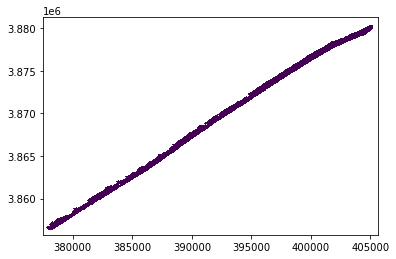

In [11]:
plt.pcolormesh(eUTM,nUTM,xds['__xarray_dataarray_variable__'][0][:][:])

### Make y and x values for regular UTM grid

In [12]:
# use floor and ceil to trim the grid to even 10-m inside the data
dx = 5.
dy = 5.
emin = (10.*np.ceil(np.amin(eUTM)/10.))
emax = (10*np.floor(np.amax(eUTM)/10.))
nmin = (10.*np.ceil(np.amin(nUTM)/10.))
nmax = (10*np.floor(np.amax(nUTM)/10.))
eUTMi = np.arange(emin,emax+dx,dx)
nUTMi = np.arange(nmin,nmax+dy,dy)

In [13]:
z = (xds['__xarray_dataarray_variable__'][0][:][:].to_numpy())
print(np.shape(z))
print(np.shape(nUTM))

(1500, 36500)
(1500, 36500)


In [14]:
f = interpolate.interp2d(nUTM, eUTM, z, kind ='linear')

OverflowError: Too many data points to interpolate

### This is how I would interpolate if the f() function worked

In [ ]:
# Array for interpolated elevations
zi=np.NaN*np.ones((nUTMi,eUTMi))
print(np.shape(zi))

# this is the fast iteration, which only works when all of the source points fall inside the target box,
# but I get an error saying `OverflowError: Too many data points to interpolate`
# zi=f((nUTMi,eUTMi))

# this is a slow iteration through all of the points, but allows us to skip ones that are outside
for ij in np.ndindex(zi.shape):
#     try:
    zi[ij]=f((nUTMi[ij],eUTMi[ij]))
#     except:
#         zi[ij]=np.NaN

### There is a way to interpolate in xarray
...but I cant even figure out how to replace the alongshore and cross-shore coordinates with the UTM values.


In [ ]:
da_utm = xr.DataArray(data=xds['__xarray_dataarray_variable__'][0][:][:].to_numpy(),dims=['northing','easting'],
                      coords = {northing = (["northing", "easting"], northing),
                                easting = (['northing', 'easting'], easting)
                               })
da_utm